In [4]:
# Victor Z
# UW-Madison, 2019
# samples of multivariate Gaussian lie on ellipse
# used GPT to translate Matlab to Python file

In [1]:
# define ellipse function
# adapted from ellipse.m - Copyright (C) 2001, James B. Rawlings and John W. Eaton

import numpy as np

def ellipse(amat, level, n=100, shift=None):
    if shift is None:
        shift = np.array([0, 0])

    shift = np.asarray(shift)

    if shift.shape != (2,):
        if shift.shape == (2, 1):
            shift = shift.flatten()
        else:
            raise ValueError("shift must be a 2-element row vector")

    if amat.shape != (2, 2):
        raise ValueError("amat must be a 2x2 matrix")

    # Eigenvalues and eigenvectors
    vals, vecs = np.linalg.eig(amat / level)

    if np.any(np.iscomplex(vals)) or np.any(vals <= 0):
        raise ValueError("ellipse: amat must be positive definite")

    # Generate contour data
    a = 1 / np.sqrt(vals[0])
    b = 1 / np.sqrt(vals[1])

    t = np.linspace(0, 2 * np.pi, n)

    xt = a * np.cos(t)
    yt = b * np.sin(t)

    # Rotate the contours
    ra = np.arctan2(vecs[1, 0], vecs[0, 0])

    cos_ra = np.cos(ra)
    sin_ra = np.sin(ra)

    x = xt * cos_ra - yt * sin_ra + shift[0]
    y = xt * sin_ra + yt * cos_ra + shift[1]

    # Endpoints of the major and minor axes
    minor = vecs @ np.diag([a, b])
    major = np.copy(minor)

    major[:, 1] = -major[:, 0]
    minor[:, 0] = -minor[:, 1]

    major += shift
    minor += shift

    # Bounding box for the ellipse using magic formula
    ainv = np.linalg.inv(amat)
    xbox = np.sqrt(level * ainv[0, 0])
    ybox = np.sqrt(level * ainv[1, 1])

    bbox = np.array([
        [xbox, ybox],
        [xbox, -ybox],
        [-xbox, -ybox],
        [-xbox, ybox],
        [xbox, ybox]
    ])

    bbox += shift

    return x, y, major, minor, bbox


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from mpl_toolkits.mplot3d import Axes3D

# specify mean and covariance
mu = np.array([0, 0])
Sigma = np.array([[1, -0.7], [-0.7, 1]])  # anti-correlated

# compute the 95% confidence interval ellipse
alpha = 0.95  # confidence
n = 2         # dimension of variable
A = np.linalg.inv(Sigma)  # inverse covariance
b = chi2.ppf(alpha, n)      # confidence level on 2d from chi2 distribution
xe, ye, major, minor, bbox = ellipse(A, b, 100, mu)  # ellipse

In [5]:
# count the number of samples in the ellipse
np.random.seed(0)
nsample = 1000  # number of random samples
sample = np.random.multivariate_normal(mu, Sigma, nsample)  # collect samples

cnt = 0
for i in range(nsample):
    x = sample[i] - mu
    if x @ np.linalg.inv(Sigma) @ x <= b:  # count if in the confidence interval
        cnt += 1

print(f'{cnt} among {nsample} samples in the ellipse')  # print the result


954 among 1000 samples in the ellipse


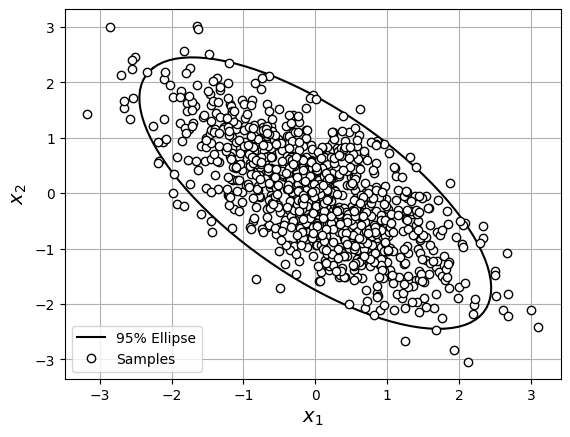

In [6]:
# plot the ellipse and the samples
plt.figure(1)
plt.plot(xe, ye, 'k', linewidth=1.5)  # plot ellipse
plt.plot(sample[:, 0], sample[:, 1], 'ko', markerfacecolor='w')  # plot samples
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.legend(['95% Ellipse', 'Samples'], loc='lower left')
plt.grid(True)
plt.show()